In [18]:
# importing libs

import pandas as pd
import numpy as np
import torch
import evaluate
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding)

from sklearn.model_selection import train_test_split




In [19]:
# check gpu

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [20]:
# load data

df = pd.read_excel("dataset.xlsx")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Dataset shape: (4897, 2)
Columns: ['posts', 'labels']


,posts,labels
0,কিভাবে হতাশা থেকে রক্ষা পাওয়া যাবে,2
1,"মাথা সঠিক কাজ করে না, মানসিক বিষন্বতা, দুঃসচিন...",3
2,আমি বেশ কিছুদিন যাবৎ অনেক ডিপ্রেসন এ আছি। আমার...,2
3,কোনো ভাবেই ডিপ্রেশন থেকে বেরিয়ে আসতে পারতেছি না,2
4,আমার বয়স ৩৪ বছর।জীবনে সবকিছু আমার মত করে পেতে ...,2


In [21]:
#Basic cleaning

df = df.dropna(subset=['posts', 'labels'])
df.shape


(4897, 2)

In [22]:
# label mapping

label_map = {1:0, 2:1, 3:2, 4:3}
df['labels'] = df['labels'].map(label_map)

df.head()

,posts,labels
0,কিভাবে হতাশা থেকে রক্ষা পাওয়া যাবে,1
1,"মাথা সঠিক কাজ করে না, মানসিক বিষন্বতা, দুঃসচিন...",2
2,আমি বেশ কিছুদিন যাবৎ অনেক ডিপ্রেসন এ আছি। আমার...,1
3,কোনো ভাবেই ডিপ্রেশন থেকে বেরিয়ে আসতে পারতেছি না,1
4,আমার বয়স ৩৪ বছর।জীবনে সবকিছু আমার মত করে পেতে ...,1


In [23]:
df.dropna(subset=['labels'])
df['labels'] = df['labels'].astype(int)

df.shape

(4897, 2)

In [24]:
# split

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=42)



In [25]:
#convert to dataset format

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [26]:
dataset = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

print(f"Training samples: {len(train_dataset)} (80%)")
print(f"Validation samples: {len(val_dataset)} (10%)")
print(f"Testing samples: {len(test_dataset)} (10%)")

Training samples: 3917 (80%)
Validation samples: 490 (10%)
Testing samples: 490 (10%)


In [27]:
#Using BanglaBERT

MODEL_ID = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [28]:
def preprocess_function(examples):
    # Max length 128 is optimized for RTX 3050 VRAM. 
    # If you get memory errors, reduce to 64. If you have space, try 256.
    return tokenizer(examples["posts"], truncation=True, max_length=128)

tokenized_dataset = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 490/490 [00:00<00:00, 19500.25 examples/s]


In [29]:
# Model Initialization

id2label = {0:"None", 1:"Mild", 2:"Medium", 3:"Severe"}
label2id = {"None":0, "Mild":1, "Medium": 2, "Severe":3}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID, 
    num_labels=4,
    id2label=id2label,
    label2id=label2id
)
model.to(device)


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1045.90it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: sagorsarker/bangla-bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSIN

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [30]:
# Metrics

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    acc = accuracy.compute(predictions=predictions, references=labels)
    # 'weighted' handles class imbalance common in mental health data
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")
    prec = precision.compute(predictions=predictions, references=labels, average="weighted")
    rec = recall.compute(predictions=predictions, references=labels, average="weighted")
    
    return {
        "accuracy": acc["accuracy"],
        "f1": f1_score["f1"],
        "precision": prec["precision"],
        "recall": rec["recall"]
    }

In [31]:
# Training arguments [hyperparameters]

batch_size = 8
epochs = 5
learning_rate = 2e-5



training_args = TrainingArguments(
    output_dir="./bangla_depression_model",
    learning_rate=learning_rate,              # MIRoBERTa recommended rate [3]
    per_device_train_batch_size=batch_size,   # Optimized for 3050 GPU
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,   # Effective batch size = 8*2 = 16
    num_train_epochs=epochs,              # Good starting point
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,                       # Mixed precision (Faster & saves VRAM)
    logging_dir='./logs',
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [35]:


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    
    # CHANGE: Use validation set for evaluation during training
    eval_dataset=tokenized_dataset["validation"], 
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.591783,0.806122,0.802669,0.807528,0.806122
2,No log,0.594676,0.802041,0.802656,0.805299,0.802041
3,1.195647,0.614081,0.814286,0.814162,0.814499,0.814286
4,1.195647,0.735497,0.806122,0.806706,0.807479,0.806122
5,0.397195,0.813138,0.810204,0.811734,0.814653,0.810204


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer

TrainOutput(global_step=1225, training_loss=0.6786111979581871, metrics={'train_runtime': 1306.439, 'train_samples_per_second': 14.991, 'train_steps_per_second': 0.938, 'total_flos': 1087256585015640.0, 'train_loss': 0.6786111979581871, 'epoch': 5.0})

In [37]:
print("\nRunning Final Evaluation on Test Set...")
test_results = trainer.evaluate(tokenized_dataset["test"])
print(test_results)



Running Final Evaluation on Test Set...


{'eval_loss': 0.5816081762313843, 'eval_accuracy': 0.7612244897959184, 'eval_f1': 0.7523395851947908, 'eval_precision': 0.7547571677919763, 'eval_recall': 0.7612244897959184, 'eval_runtime': 2.5501, 'eval_samples_per_second': 192.151, 'eval_steps_per_second': 24.313, 'epoch': 5.0}


Generating predictions...


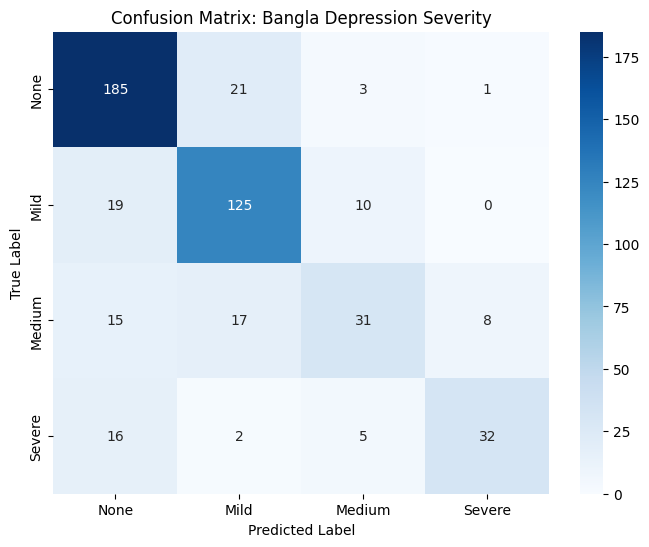

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get Predictions on the Test Set
print("Generating predictions...")
predictions_output = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# 2. Define Class Names (Map 0,1,2,3 back to text)
# Ensure this matches the order you used in label2id earlier
class_names = ["None", "Mild", "Medium", "Severe"] 

# 3. Create Confusion Matrix
cm = confusion_matrix(true_labels, preds)

# 4. Plot Heatmap (MIRoBERTa Style)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Bangla Depression Severity')
plt.show()

In [40]:
print(classification_report(true_labels, preds, target_names=class_names))

              precision    recall  f1-score   support

        None       0.79      0.88      0.83       210
        Mild       0.76      0.81      0.78       154
      Medium       0.63      0.44      0.52        71
      Severe       0.78      0.58      0.67        55

    accuracy                           0.76       490
   macro avg       0.74      0.68      0.70       490
weighted avg       0.75      0.76      0.75       490



In [42]:
import shap
import torch

# 1. Define a prediction function wrapper
# SHAP needs a function that takes a list of texts and returns probabilities
def f(texts):
    # Ensure texts are strings
    texts = [str(text) for text in texts]
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Apply Softmax to get probabilities (scores between 0 and 1)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()
    return scores

# 2. Initialize the Explainer with a proper text masker
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(f, masker)

# 3. Select examples to explain
# Let's pick 3 examples from the TEST set to see why the model classified them that way
examples_to_explain = test_df['posts'].iloc[0:3].tolist()

# 4. Calculate SHAP values
print("Calculating SHAP values (this may take a minute)...")
shap_values = explainer(examples_to_explain)

# 5. Visualize
# This creates the red/blue highlight text plot seen in the MIRoBERTa paper (Fig 4)
shap.plots.text(shap_values)

Calculating SHAP values (this may take a minute)...


In [38]:
model.save_pretrained("./bangla_depression_1")
tokenizer.save_pretrained("./bangla_depression_1")

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


('./bangla_depression_1\\tokenizer_config.json',
 './bangla_depression_1\\tokenizer.json')